In [1]:
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader
from ibllib.atlas import AllenAtlas
from brainbox.core import TimeSeries
from brainbox.processing import bin_spikes
import neo.core
from quantities import s
import quantities
import numpy as np
import pandas as pd

In [2]:
pw = 'international'
one = ONE(base_url='https://openalyx.internationalbrainlab.org', password=pw, silent=True)
Atlas = AllenAtlas()
#pid = 'da8dfec1-d265-44e8-84ce-6ae9c109b8bd'
eid = 'dda5fc59-f09a-4256-9fb5-66c67667a466'
pid = '69f42a9c-095d-4a25-bca8-61a9869871d3'

In [3]:
sl = SpikeSortingLoader(pid=pid, one=one, atlas=Atlas)
spikes, clusters, channels = sl.load_spike_sorting()
clusters = sl.merge_clusters(spikes, clusters, channels)
trials = one.load_object(eid, 'trials', collection='alf')

### Getting choice data and IDs into one dictionary

In [ ]:
sl.raster(spikes, channels)

In [5]:
np.unique(clusters['acronym'])

array(['APN', 'CA1', 'DG-mo', 'DG-po', 'DG-sg', 'Eth', 'LP', 'MB', 'PoT',
       'SPFp', 'TH', 'VISam1', 'VISam2/3', 'VISam4', 'VISam6b',
       'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b', 'alv', 'fp',
       'ml', 'or', 'void'], dtype=object)

Find good clusters, all IBL designed metrics pass if the label is 1 --> stronger clusters

In [4]:
good_ids = clusters['cluster_id'][((clusters['label'] == 1) & 
                                   ([True if "VIS" in s else False for s in clusters['acronym']]))]

In [5]:
locations = [True if i in good_ids else False for i in spikes['clusters']]

In [6]:
good_spikes = {key:val[locations] for key, val in spikes.items()}
good_spikes

{'amps': array([1.44531807e-04, 6.60806266e-05, 9.26445925e-05, ...,
        1.39537684e-04, 3.01478905e-04, 1.28412383e-04]),
 'clusters': array([397, 537, 435, ..., 391, 382, 425], dtype=uint32),
 'depths': array([3030.87451172, 3119.68310547, 3154.67578125, ..., 3041.03344727,
        2982.41064453, 3134.62915039]),
 'times': array([2.31666667e-02, 2.52333333e-02, 2.92333333e-02, ...,
        6.30179317e+03, 6.30179717e+03, 6.30182763e+03])}

In [7]:
trial_start = list(map(lambda x: x[0], trials['intervals']))
trial_end = list(map(lambda x: x[1], trials['intervals']))

In [8]:
data_dct = {}

In [9]:
cluster_peaks = []
for i in range(len(good_spikes['times'])):
    interval_dct = {}
    if (good_spikes['times'][i] >= trial_start[0]) and ((good_spikes['times'][i] <= trial_end[-1])):
        cluster_peaks += [(good_spikes['clusters'][i], good_spikes['times'][i])]

In [10]:
data_dct['times'] = list(map(lambda x: x[1], cluster_peaks))
data_dct['id'] = list(map(lambda x: x[0], cluster_peaks))

In [11]:
good_spikes = data_dct

(<Figure size 1152x648 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'2020-09-21_1_SWC_043_probe00, da8dfec1-d265-44e8-84ce-6ae9c109b8bd \n4_139_263 spikes, 165 clusters'}>,
         <AxesSubplot:>],
        [<AxesSubplot:xlabel='time (secs)', ylabel='depth (um)'>,
         <AxesSubplot:title={'center':'alf'}>]], dtype=object))

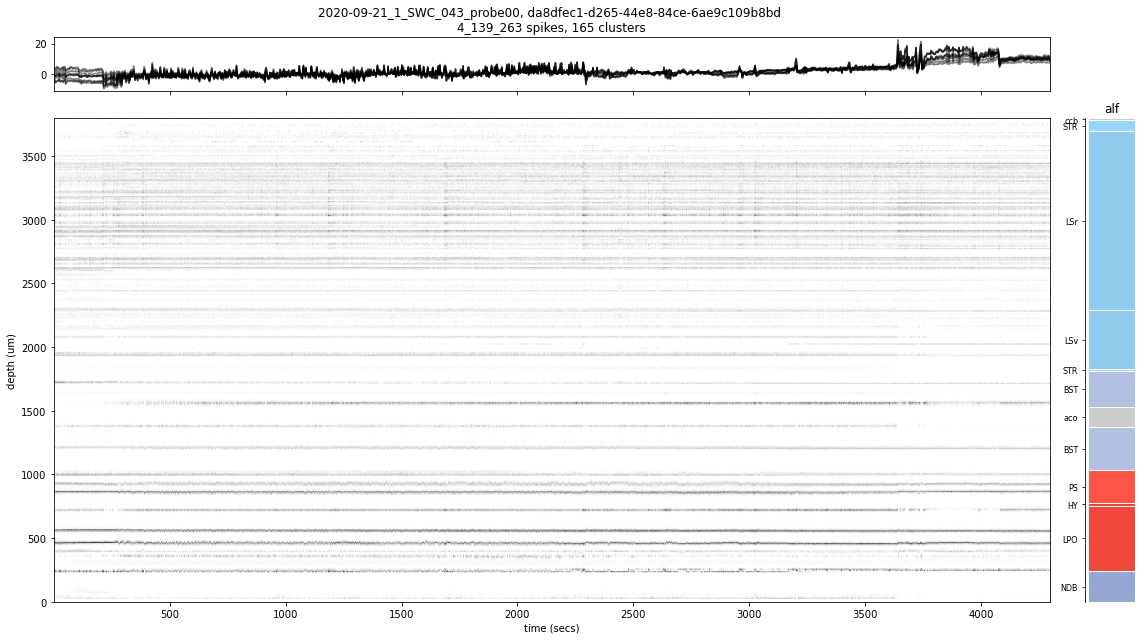

In [9]:
sl.raster(good_spikes, channels)

In [12]:
times_per_cluster = {}
for idx in range(len(good_spikes['id'])):
    #if (good_spikes['times'][idx] >= 50):
    if (good_spikes['id'][idx] not in times_per_cluster.keys()):
        times_per_cluster[good_spikes['id'][idx]] =[good_spikes['times'][idx]]
    else:
        times_per_cluster[good_spikes['id'][idx]] += [good_spikes['times'][idx]]

In [35]:
x = (list(map(lambda x: round(x, 1), times_per_cluster[395])))
print(len(x))
x = list(np.unique(x))
x
print(len(x))

88513
36761


In [13]:
from vlgpax.kernel import RBF
from vlgpax import Session, vi

In [14]:
df = pd.DataFrame(columns = ['times'], index = times_per_cluster.keys())
for time in times_per_cluster.keys():
    df.loc[time] = pd.Series({'times': times_per_cluster[time]})

In [15]:
end_idx = 10
new_df = pd.DataFrame(index = np.arange(round(trial_start[0]), round(trial_end[end_idx])), columns = df.index)
times_arr = np.arange(round(trial_start[0]), round(trial_end[end_idx]))
for i in range(len(df)):
    times = df.iloc[i]['times']
    times = list(map(lambda x: round(x), times))
    for time in times_arr:
        if time in times:
            new_df.loc[time][df.index[i]] = 1
        else:
            new_df.loc[time][df.index[i]] = 0

In [111]:
choices = trials['choice']
choice_arr = []
counter = 0
for i in range(len(times_arr)):
    if times_arr[i] in np.arange(round(trial_start[counter]), round(trial_end[counter])):
        choice_arr += [choices[counter]]
    else:
        choice_arr += [choices[counter+1]]
        counter+=1

In [28]:
dt = 0.005
#dt = 1
session = Session(dt)
y = new_df

# Session is the top level container of data. Two arguments, binsize and unit of time, are required at construction.
for i in range(0, len(new_df), 3):
    z = np.array(new_df.iloc[i:i+3]).reshape(-3, 3)
    session.add_trial(i, y = z)
    #print(np.array(new_df.iloc[i:i+2]).reshape(-3,3).shape) # Add trials to the session.

# Build the model
kernel = RBF(scale = 1., lengthscale = 25 * dt)  # RBF kernel

In [29]:
random_seed = 20221011
np.random.seed(random_seed)
session, params = vi.fit(session, n_factors=2, kernel=kernel, seed=random_seed, max_iter=50, trial_length = 25)
#X_hat_VLGP = rearrange(session.z, '(trials time) lat -> trials time lat', time=165)
#P_hat_VLGP = rearrange(session.v, '(trials time) lat -> trials time lat', time=165)

Initializing
Initialized
EM Iteration 1, 	Loss = -4.8101, 	M step: 0.92s, 	E step: 1.40s
EM Iteration 2, 	Loss = -4.9517, 	M step: 0.05s, 	E step: 0.06s
EM Iteration 3, 	Loss = -4.9022, 	M step: 0.07s, 	E step: 0.08s
Inferring
Trial 0, 	Loss = -4.8884
Trial 3, 	Loss = -4.9296
Trial 6, 	Loss = -4.8464
Trial 9, 	Loss = -4.8623
Trial 12, 	Loss = -4.8608
Trial 15, 	Loss = -4.8052
Trial 18, 	Loss = -4.9994
Trial 21, 	Loss = -4.9547
Trial 24, 	Loss = -4.9605
Trial 27, 	Loss = -4.9769
Trial 30, 	Loss = -4.9469
Trial 33, 	Loss = -4.7585
Trial 36, 	Loss = -5.0014
Trial 39, 	Loss = -4.9419
Trial 42, 	Loss = -4.9142
Trial 45, 	Loss = -4.7847
Trial 48, 	Loss = -4.9523


/home/jmakki/.local/lib/python3.9/site-packages/vlgpax/vi.py:405: UserWarning: EM: loss increased
  warnings.warn('EM: loss increased')
/home/jmakki/.local/lib/python3.9/site-packages/vlgpax/vi.py:160: UserWarning: E: loss increased
  warnings.warn('E: loss increased')


Trial 51, 	Loss = -4.8652
Finished


In [30]:
from einops import rearrange
X_hat_VLGP = rearrange(session.z, '(trials time) lat -> trials time lat', time=1)
P_hat_VLGP = rearrange(session.v, '(trials time) lat -> trials time lat', time=1)

In [31]:
import matplotlib.pyplot as plt
#plt.plot(session.z[:, 0], session.z[:, 1], session.z[:, 2], alpha=0.3, color="red")
#plt.plot(X_hat_VLGP, P_hat_VLGP)
len(X_hat_VLGP)

450

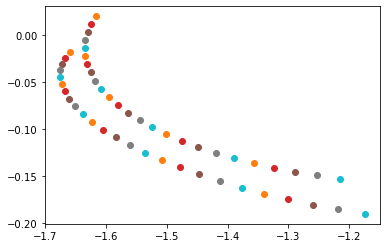

In [37]:
for k in range(50):
    plt.plot(X_hat_VLGP[k,:,0],  X_hat_VLGP[k,:,1])
    plt.plot(X_hat_VLGP[k,-1,0], X_hat_VLGP[k,-1,1], 'o')

## Bin by interval

In [41]:
interval_times_per_cluster = {}
#times_per_cluster = {}
for i in range(len(trial_start)):
    dct_per_int = {}
    for idx in range(len(good_spikes['id'])):
        if (good_spikes['times'][idx] >= trial_start[i]) and (good_spikes['times'][idx]  <= trial_end[i]):
            if (good_spikes['id'][idx] not in dct_per_int.keys()):
                dct_per_int[good_spikes['id'][idx]] = [good_spikes['times'][idx]]
            else:
                dct_per_int[good_spikes['id'][idx]] += [good_spikes['times'][idx]]
    interval_times_per_cluster[tuple(trials['intervals'][i])] = dct_per_int

In [53]:
df = pd.DataFrame(columns = np.unique(good_spikes['id']), index = interval_times_per_cluster.keys())

for interval in interval_times_per_cluster.keys():
    clusters = interval_times_per_cluster[interval].keys()
    for clust in df.columns:
        if clust in clusters:
            df.loc[interval][clust] = 1
        else:
            df.loc[interval][clust] = 0

In [58]:
df

,,349,360,362,382,383,384,388,391,395,397,...,435,437,439,442,443,448,532,537,554,557
33.607000,36.753533,0,1,0,0,1,1,1,1,1,1,...,1,0,0,0,1,1,0,1,0,0
37.143033,40.686466,0,1,0,0,1,1,1,1,1,1,...,1,0,1,0,1,1,0,1,0,0
41.063667,44.236799,0,1,0,0,1,1,1,1,1,1,...,1,0,1,0,1,1,0,1,0,0
44.642100,48.969963,0,1,0,0,1,1,1,1,1,1,...,1,1,1,0,1,1,0,1,0,0
49.343067,55.686400,0,1,0,0,1,1,1,1,1,1,...,1,0,1,0,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3747.987467,3750.603393,0,0,0,1,0,1,1,1,1,1,...,0,0,1,0,0,0,1,0,0,0
3751.553400,3758.324460,0,1,1,1,0,1,1,1,1,1,...,1,0,0,1,0,0,1,1,0,1
3759.263567,3767.124457,0,1,1,1,0,1,1,1,1,1,...,1,1,1,1,0,0,1,1,0,0
3768.086367,3781.657793,0,1,0,1,0,1,1,1,1,1,...,1,1,1,1,0,1,1,1,0,0


In [88]:
df['choice'] = trials['choice']
df['correct'] = trials['feedbackType']

In [90]:
dt = 0.005
#dt = 1
choiceLeft = Session(dt)
choiceRight = Session(dt)
choiceLeftC = Session(dt)
choiceRightC = Session(dt)

# Session is the top level container of data. Two arguments, binsize and unit of time, are required at construction.
for i in range(0, 40):
    if df.iloc[i]['choice'] > 0:
        if df.iloc[i]['correct'] > 0:
            choiceRightC.add_trial(i, np.array(df[df.columns[:-1]].iloc[i]).reshape(-1,1))
        else:
            choiceRight.add_trial(i, np.array(df[df.columns[:-1]].iloc[i]).reshape(-1,1))
    else:
        if df.iloc[i]['correct'] > 0: 
            choiceLeftC.add_trial(i, np.array(df[df.columns[:-1]].iloc[i]).reshape(-1, 1))
        else:
            choiceLeft.add_trial(i, np.array(df[df.columns[:-1]].iloc[i]).reshape(-1, 1))

# Build the model
kernel = RBF(scale = 1., lengthscale = 25 * dt)  # RBF kernel

In [99]:
random_seed = 20221011
np.random.seed(random_seed)
left, params = vi.fit(choiceLeftC, n_factors=1, kernel=kernel, seed=random_seed, max_iter=50, trial_length = 25)

Initializing
Initialized
EM Iteration 1, 	Loss = 1.4093, 	M step: 0.08s, 	E step: 0.04s
EM Iteration 2, 	Loss = 1.4604, 	M step: 0.08s, 	E step: 0.10s
Inferring


/home/jmakki/.local/lib/python3.9/site-packages/vlgpax/vi.py:405: UserWarning: EM: loss increased
  warnings.warn('EM: loss increased')


Trial 0, 	Loss = 1.4183
Trial 1, 	Loss = 1.4479
Trial 2, 	Loss = 1.4237
Trial 6, 	Loss = 1.4015
Trial 8, 	Loss = 1.4228
Trial 10, 	Loss = 1.4719
Trial 11, 	Loss = 1.4761
Trial 19, 	Loss = 1.3518
Trial 21, 	Loss = 1.4719
Trial 22, 	Loss = 1.4237
Trial 25, 	Loss = 1.4527
Trial 27, 	Loss = 1.4237
Trial 28, 	Loss = 1.4226
Trial 29, 	Loss = 1.4009
Trial 30, 	Loss = 1.5166
Trial 32, 	Loss = 1.4193
Trial 33, 	Loss = 1.4719
Trial 34, 	Loss = 1.3982
Trial 35, 	Loss = 1.4600
Trial 36, 	Loss = 1.4154
Trial 37, 	Loss = 1.2892
Trial 39, 	Loss = 1.4852
Finished


In [100]:
right, params2 = vi.fit(choiceRight, n_factors=1, kernel=kernel, seed=random_seed, max_iter=50, trial_length = 25)

Initializing
Initialized
EM Iteration 1, 	Loss = 1.4701, 	M step: 0.01s, 	E step: 0.09s
EM Iteration 2, 	Loss = 1.5507, 	M step: 0.02s, 	E step: 0.01s
Inferring
Trial 15, 	Loss = 1.5487
Trial 31, 	Loss = 1.5452
Finished


/home/jmakki/.local/lib/python3.9/site-packages/vlgpax/vi.py:405: UserWarning: EM: loss increased
  warnings.warn('EM: loss increased')


In [101]:
rightC, params2 = vi.fit(choiceRightC, n_factors=1, kernel=kernel, seed=random_seed, max_iter=50, trial_length = 25)

Initializing
Initialized
EM Iteration 1, 	Loss = 1.4351, 	M step: 0.04s, 	E step: 0.03s
EM Iteration 2, 	Loss = 1.4827, 	M step: 0.05s, 	E step: 0.07s
Inferring
Trial 3, 	Loss = 1.4897
Trial 4, 	Loss = 1.5074
Trial 5, 	Loss = 1.4692
Trial 7, 	Loss = 1.5056
Trial 9, 	Loss = 1.4897
Trial 12, 	Loss = 1.5074
Trial 13, 	Loss = 1.4692
Trial 14, 	Loss = 1.4893
Trial 16, 	Loss = 1.5073
Trial 17, 	Loss = 1.5046
Trial 18, 	Loss = 1.3974
Trial 20, 	Loss = 1.4692
Trial 23, 	Loss = 1.4897
Trial 24, 	Loss = 1.5215
Trial 26, 	Loss = 1.4489
Trial 38, 	Loss = 1.4244
Finished


/home/jmakki/.local/lib/python3.9/site-packages/vlgpax/vi.py:405: UserWarning: EM: loss increased
  warnings.warn('EM: loss increased')


In [102]:
Left_VLGP = rearrange(left.z, '(trials time) lat -> trials time lat', time=1)
Right_VLGP = rearrange(right.z, '(trials time) lat -> trials time lat', time=1)
rightC_VLP = rearrange(rightC.z, '(trials time) lat -> trials time lat', time=1)

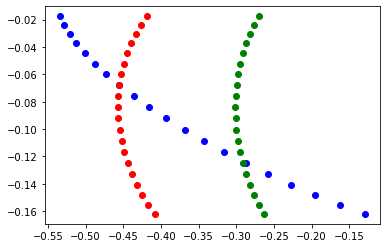

In [107]:
for k in range(20):
    plt.plot(Left_VLGP[k,:,0],  X_hat_VLGP[k,:,1])
    plt.plot(Left_VLGP[k,-1,0], X_hat_VLGP[k,-1,1], 'o', color = 'blue')
    plt.plot(Right_VLGP[k,:,0],  X_hat_VLGP[k,:,1])
    plt.plot(Right_VLGP[k,-1,0], X_hat_VLGP[k,-1,1], 'o', color = 'red')
    plt.plot(rightC_VLP[k,:,0],  X_hat_VLGP[k,:,1])
    plt.plot(rightC_VLP[k,-1,0], X_hat_VLGP[k,-1,1], 'o', color = 'green')